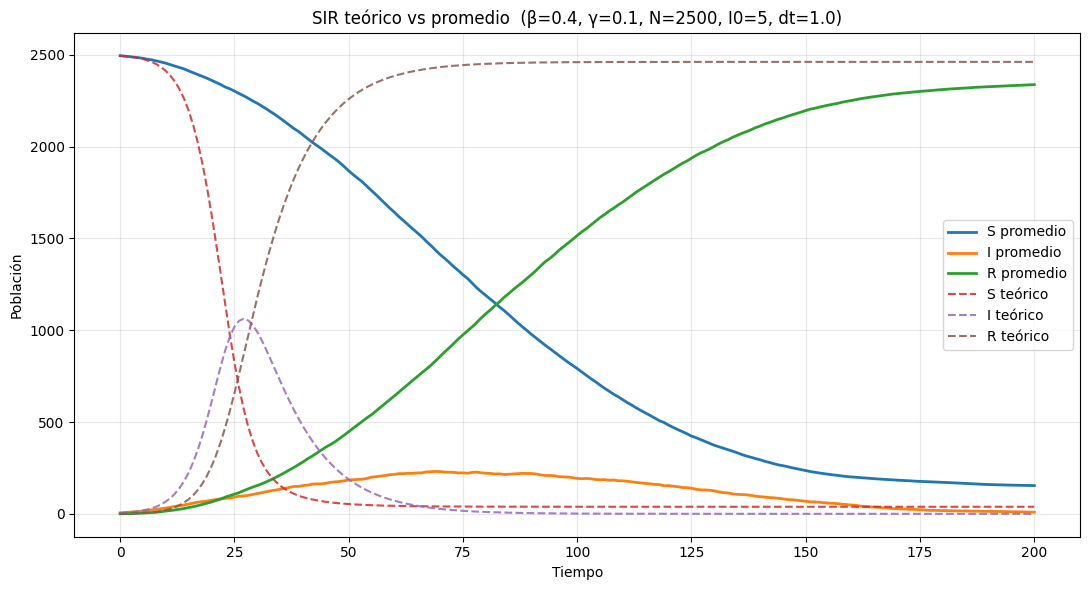

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt

# -------- Configura aquí --------
json_path = "./out/sir_grid_results.json"  # o sir_particles_results.json

# -------- Utilidades --------
def load_mean_from_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    meta = data.get("meta", {})
    mean = data.get("mean", None)
    runs = data.get("runs", [])
    if mean is not None:
        t = np.array(mean["t"], dtype=float)
        S = np.array(mean["s"], dtype=float)
        I = np.array(mean["i"], dtype=float)
        R = np.array(mean["r"], dtype=float)
        return t, S, I, R, meta
    # Si no hay mean, promediamos runs:
    L = min(len(r["t"]) for r in runs)
    t = np.array(runs[0]["t"][:L], dtype=float)
    accS = np.zeros(L); accI = np.zeros(L); accR = np.zeros(L)
    for r in runs:
        accS += np.array(r["s"][:L], dtype=float)
        accI += np.array(r["i"][:L], dtype=float)
        accR += np.array(r["r"][:L], dtype=float)
    n = len(runs)
    return t, accS/n, accI/n, accR/n, meta

def infer_params(meta):
    p = meta.get("params", {})
    # Población total
    if "Ntotal" in p:
        N = int(p["Ntotal"])
    elif "M" in p and "N" in p:
        N = int(p["M"] * p["N"])
    else:
        raise ValueError("No se pudo inferir N (Ntotal o M,N).")
    # Beta y gamma (en grid, gamma viene como alpha)
    beta = float(p["beta"])
    gamma = float(p["gamma"]) if "gamma" in p else float(p.get("alpha", 0.0))
    # Paso de tiempo
    dt = float(p["dt"]) if "dt" in p else 1.0
    # I0
    I0 = int(p["I0"])
    return N, beta, gamma, I0, dt


def sir_euler(N, beta, gamma, I0, T_steps, dt=1.0):
    S = np.zeros(T_steps+1); I = np.zeros(T_steps+1); R = np.zeros(T_steps+1)
    S[0] = N - I0; I[0] = I0; R[0] = 0.0
    t = np.arange(T_steps+1)*dt
    for k in range(T_steps):
        dS = -beta * S[k] * I[k] / N
        dI =  beta * S[k] * I[k] / N - gamma * I[k]
        dR =  gamma * I[k]
        S[k+1] = S[k] + dt*dS
        I[k+1] = I[k] + dt*dI
        R[k+1] = R[k] + dt*dR
    return t, S, I, R

# -------- Cargar promedio del JSON --------
t_mean, S_mean, I_mean, R_mean, meta = load_mean_from_json(json_path)

# -------- Inferir parámetros y generar teoría --------
N, beta, gamma, I0, dt_json = infer_params(meta)
# Número de pasos para teoría: igual al del promedio
T_steps = len(t_mean) - 1
# Si tu JSON del grid tiene dt implícito de 1, t_mean ya está en pasos; usamos ese dt
dt_theory = (t_mean[1]-t_mean[0]) if len(t_mean) > 1 else (1.0 if "dt" not in meta.get("params", {}) else dt_json)

t_th, S_th, I_th, R_th = sir_euler(N, beta, gamma, I0, T_steps, dt=dt_theory)

# -------- Graficar --------
plt.figure(figsize=(11,6))
plt.plot(t_mean, S_mean, label="S promedio", lw=2)
plt.plot(t_mean, I_mean, label="I promedio", lw=2)
plt.plot(t_mean, R_mean, label="R promedio", lw=2)

plt.plot(t_th, S_th, "--", label="S teórico", alpha=0.85)
plt.plot(t_th, I_th, "--", label="I teórico", alpha=0.85)
plt.plot(t_th, R_th, "--", label="R teórico", alpha=0.85)

title = f"SIR teórico vs promedio  (β={beta}, γ={gamma}, N={N}, I0={I0}, dt={dt_theory})"
plt.title(title)
plt.xlabel("Tiempo"); plt.ylabel("Población")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()


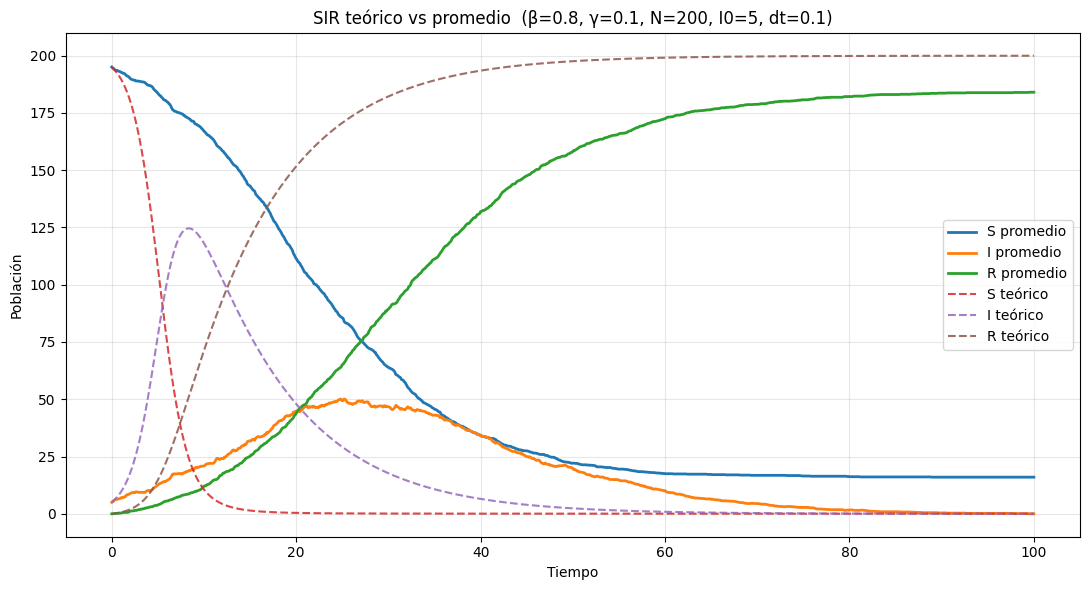

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt

# -------- Configura aquí --------
json_path = "./out/sir_particles_results.json"  # o sir_particles_results.json

# -------- Utilidades --------
def load_mean_from_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    meta = data.get("meta", {})
    mean = data.get("mean", None)
    runs = data.get("runs", [])
    if mean is not None:
        t = np.array(mean["t"], dtype=float)
        S = np.array(mean["s"], dtype=float)
        I = np.array(mean["i"], dtype=float)
        R = np.array(mean["r"], dtype=float)
        return t, S, I, R, meta
    # Si no hay mean, promediamos runs:
    L = min(len(r["t"]) for r in runs)
    t = np.array(runs[0]["t"][:L], dtype=float)
    accS = np.zeros(L); accI = np.zeros(L); accR = np.zeros(L)
    for r in runs:
        accS += np.array(r["s"][:L], dtype=float)
        accI += np.array(r["i"][:L], dtype=float)
        accR += np.array(r["r"][:L], dtype=float)
    n = len(runs)
    return t, accS/n, accI/n, accR/n, meta

def infer_params(meta):
    p = meta.get("params", {})
    # Población total
    if "Ntotal" in p:
        N = int(p["Ntotal"])
    elif "M" in p and "N" in p:
        N = int(p["M"] * p["N"])
    else:
        raise ValueError("No se pudo inferir N (Ntotal o M,N).")
    # Beta y gamma (en grid, gamma viene como alpha)
    beta = float(p["beta"])
    gamma = float(p["gamma"]) if "gamma" in p else float(p.get("alpha", 0.0))
    # Paso de tiempo
    dt = float(p["dt"]) if "dt" in p else 1.0
    # I0
    I0 = int(p["I0"])
    return N, beta, gamma, I0, dt


def sir_euler(N, beta, gamma, I0, T_steps, dt=1.0):
    S = np.zeros(T_steps+1); I = np.zeros(T_steps+1); R = np.zeros(T_steps+1)
    S[0] = N - I0; I[0] = I0; R[0] = 0.0
    t = np.arange(T_steps+1)*dt
    for k in range(T_steps):
        dS = -beta * S[k] * I[k] / N
        dI =  beta * S[k] * I[k] / N - gamma * I[k]
        dR =  gamma * I[k]
        S[k+1] = S[k] + dt*dS
        I[k+1] = I[k] + dt*dI
        R[k+1] = R[k] + dt*dR
    return t, S, I, R

# -------- Cargar promedio del JSON --------
t_mean, S_mean, I_mean, R_mean, meta = load_mean_from_json(json_path)

# -------- Inferir parámetros y generar teoría --------
N, beta, gamma, I0, dt_json = infer_params(meta)
# Número de pasos para teoría: igual al del promedio
T_steps = len(t_mean) - 1
# Si tu JSON del grid tiene dt implícito de 1, t_mean ya está en pasos; usamos ese dt
dt_theory = (t_mean[1]-t_mean[0]) if len(t_mean) > 1 else (1.0 if "dt" not in meta.get("params", {}) else dt_json)

t_th, S_th, I_th, R_th = sir_euler(N, beta, gamma, I0, T_steps, dt=dt_theory)

# -------- Graficar --------
plt.figure(figsize=(11,6))
plt.plot(t_mean, S_mean, label="S promedio", lw=2)
plt.plot(t_mean, I_mean, label="I promedio", lw=2)
plt.plot(t_mean, R_mean, label="R promedio", lw=2)

plt.plot(t_th, S_th, "--", label="S teórico", alpha=0.85)
plt.plot(t_th, I_th, "--", label="I teórico", alpha=0.85)
plt.plot(t_th, R_th, "--", label="R teórico", alpha=0.85)

title = f"SIR teórico vs promedio  (β={beta}, γ={gamma}, N={N}, I0={I0}, dt={dt_theory})"
plt.title(title)
plt.xlabel("Tiempo"); plt.ylabel("Población")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()
